# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:15<00:00, 3.88KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

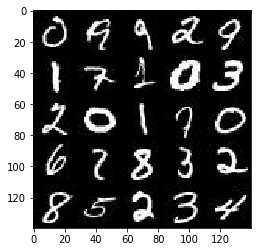

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

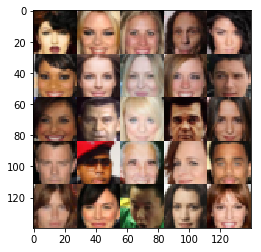

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(dtype = tf.float32, shape = (None, image_width, image_height, image_channels),
                                 name = 'real_images')
    #print (image_width, image_height, image_channels)
    
    z_input = tf.placeholder(dtype = tf.float32, shape = (None, z_dim), name = 'z_input')
    learing_rate = tf.placeholder(dtype = tf.float32, shape = None, name = 'lr')

    return real_images, z_input, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # With a wave of my wand, I generate . . . MAGIC NUMBERS! WHAM-BAM-ALAKAZAM
        d1 = tf.layers.conv2d(images, 64, 4, strides = 2, padding = 'same', 
                             kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        relu1 = tf.maximum(alpha * d1, d1)
        #print(relu1.get_shape().as_list())
        
        d2 = tf.layers.conv2d(relu1, 128, 4, strides = 2, padding = 'same', 
                             kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        bn2 = tf.layers.batch_normalization(d2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.get_shape().as_list())
        
        d3 = tf.layers.conv2d(relu2, 256, 4, strides = 2, padding = 'same', 
                             kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        bn3 = tf.layers.batch_normalization(d3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.get_shape().as_list())
        
        d4 = tf.layers.conv2d(relu3, 512, 4, strides = 2, padding = 'same', 
                             kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        bn4 = tf.layers.batch_normalization(d4, training = True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        #print(relu4.get_shape().as_list())
        
        
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1, 
                                kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2 
    
    # Alright Mr. Forums-guy, I'll try that, but it can't possibly be righ- oh fark me.
    with tf.variable_scope('generator', reuse = not is_train) as scope:
        # WHA-FLA-ABRACADABRA
        l1 = tf.layers.dense(z, 7*7*768)
        
        l1 = tf.reshape(l1, (-1, 7, 7, 768))
        l1 = tf.layers.batch_normalization(l1, training = is_train)
        l1 = tf.maximum(alpha * l1, l1)
        #print(l1.get_shape().as_list())
        
        l2 = tf.layers.conv2d_transpose(l1, 512, 4, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        l2 = tf.layers.batch_normalization(l2, training = is_train)
        l2 = tf.maximum(alpha * l2, l2)
        #print(l2.get_shape().as_list())
        
        l3 = tf.layers.conv2d_transpose(l2, 256, 4, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        l3 = tf.layers.batch_normalization(l3, training = is_train)
        l3 = tf.maximum(alpha * l3, l3)
        #print(l3.get_shape().as_list())
        
        l4 = tf.layers.conv2d_transpose(l3, 128, 4, strides = 1, padding = 'same', 
                                       kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        l4 = tf.layers.batch_normalization(l4, training = is_train)
        l4 = tf.maximum(alpha * l4, l4)
        #print(l4.get_shape().as_list())
        
        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 4, strides = 1, padding = 'same', 
                                           kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    gen = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen, reuse = True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_real, labels = tf.ones_like(dis_model_real) * smooth))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.zeros_like(dis_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.ones_like(dis_model_fake)))
    
    dis_loss = dis_loss_fake + dis_loss_real
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    

    # Book keeping
    print_every, show_every = 10, 100    
    _, image_width, image_height, image_channels = data_shape
    steps = 0
    losses = []
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                noize = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: noize})
                sess.run(g_opt, feed_dict = {input_z: noize, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = sess.run(d_loss, feed_dict = {input_real: batch_images, input_z: noize})
                    train_loss_g = g_loss.eval({input_z: noize})
                    
                    print('Epoch {}/{}...'.format(epoch_i + 1, epochs),
                            'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                            'Generator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    # gen_samples = sess.run(
                    #               generator(input_z, image_channels, reuse = True, training = False),
                    #               feed_dict = {input_z: sample_z})
                    # samples.append(gen_samples)
                                 
                    show_generator_output(sess, 10, input_z, image_channels, data_image_mode)
                    
            # show final each epoch
            show_generator_output(sess, 10, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6601... Generator Loss: 0.1471
Epoch 1/2... Discriminator Loss: 2.7767... Generator Loss: 0.1252
Epoch 1/2... Discriminator Loss: 1.6549... Generator Loss: 0.4063
Epoch 1/2... Discriminator Loss: 2.1257... Generator Loss: 0.2242
Epoch 1/2... Discriminator Loss: 2.1547... Generator Loss: 0.2099
Epoch 1/2... Discriminator Loss: 1.9362... Generator Loss: 0.2843
Epoch 1/2... Discriminator Loss: 1.9895... Generator Loss: 0.2568
Epoch 1/2... Discriminator Loss: 1.4522... Generator Loss: 0.4877
Epoch 1/2... Discriminator Loss: 1.6324... Generator Loss: 0.3749
Epoch 1/2... Discriminator Loss: 1.5490... Generator Loss: 0.4197


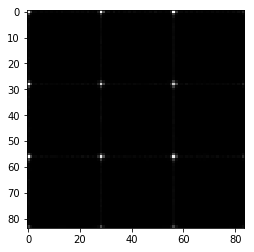

Epoch 1/2... Discriminator Loss: 1.5455... Generator Loss: 0.4153
Epoch 1/2... Discriminator Loss: 1.6170... Generator Loss: 0.3920
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.4687
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.6337


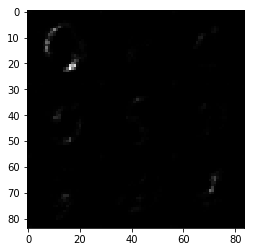

Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.5361
Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 0.9925
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 1.0156
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 2.3323
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 2.5825
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 1.1397
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.5615
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 1.1250
Epoch 1/2... Discriminator Loss: 1.9692... Generator Loss: 3.1830


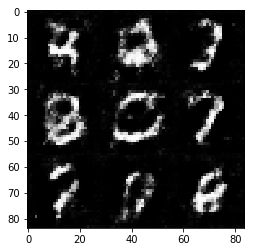

Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 2.3583
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 2.1157
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 1.1615
Epoch 1/2... Discriminator Loss: 1.4655... Generator Loss: 1.5508
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.3647
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 1.4544
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.6893
Epoch 1/2... Discriminator Loss: 1.6894... Generator Loss: 1.6830
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 1.4717
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 1.3024


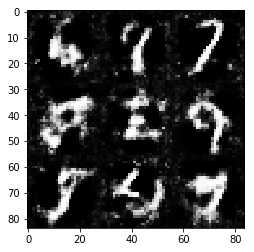

Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.6350
Epoch 1/2... Discriminator Loss: 1.8400... Generator Loss: 0.2747
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 0.5995
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 1.4160
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.2665
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 0.9426


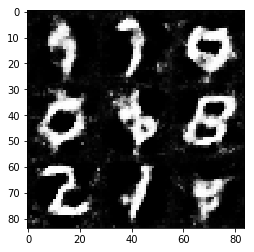

Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 1.1841
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 1.4737
Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 0.9642


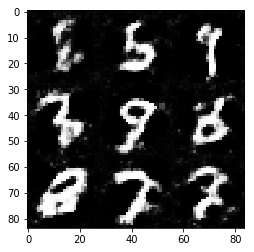

Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 1.1772
Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 1.5179
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.5405
Epoch 2/2... Discriminator Loss: 1.4077... Generator Loss: 0.5061
Epoch 2/2... Discriminator Loss: 1.4729... Generator Loss: 0.4442
Epoch 2/2... Discriminator Loss: 1.4640... Generator Loss: 0.4504
Epoch 2/2... Discriminator Loss: 1.5352... Generator Loss: 0.4047
Epoch 2/2... Discriminator Loss: 1.5558... Generator Loss: 0.3867
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.4490
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.6732


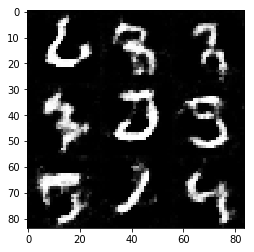

Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.4261
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.5747
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.4932
Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 0.5424
Epoch 2/2... Discriminator Loss: 1.5692... Generator Loss: 0.3978
Epoch 2/2... Discriminator Loss: 1.5151... Generator Loss: 0.4188
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 1.1222
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 1.1967


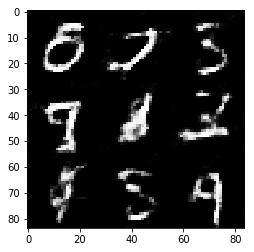

Epoch 2/2... Discriminator Loss: 1.1456... Generator Loss: 1.2922
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 1.2083
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 1.0564
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 1.7958
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 0.8488
Epoch 2/2... Discriminator Loss: 1.4409... Generator Loss: 0.4529
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.6090
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 1.3543
Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 1.3669
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.7072


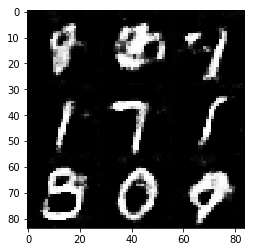

Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.5577
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 1.4335
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 1.0651
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 1.6481
Epoch 2/2... Discriminator Loss: 1.5365... Generator Loss: 0.4089
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 1.7304... Generator Loss: 0.3232
Epoch 2/2... Discriminator Loss: 2.0352... Generator Loss: 0.2439
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 0.9747


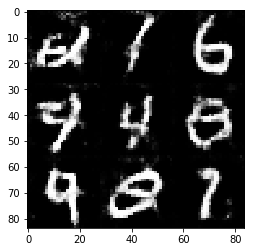

Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.8039
Epoch 2/2... Discriminator Loss: 1.5313... Generator Loss: 0.4166
Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 0.5678


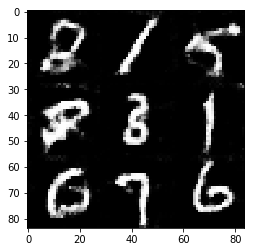

In [13]:
batch_size = 128
z_dim = 100 # was 64
learning_rate = 0.0002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.8841... Generator Loss: 0.0510
Epoch 1/1... Discriminator Loss: 3.2952... Generator Loss: 0.0720
Epoch 1/1... Discriminator Loss: 2.4172... Generator Loss: 0.1792
Epoch 1/1... Discriminator Loss: 2.1478... Generator Loss: 0.2207
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.5559


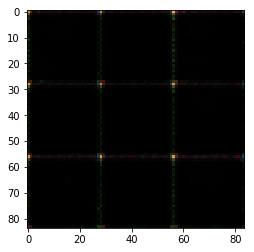

Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 2.6730
Epoch 1/1... Discriminator Loss: 1.7503... Generator Loss: 3.1875
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.5696
Epoch 1/1... Discriminator Loss: 1.7628... Generator Loss: 0.3245
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 5.4751
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 2.6558
Epoch 1/1... Discriminator Loss: 1.6437... Generator Loss: 2.3370


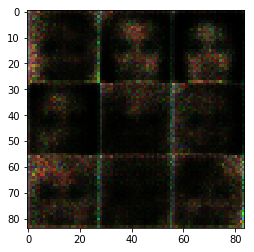

Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 2.5139
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 2.7896
Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 2.1399
Epoch 1/1... Discriminator Loss: 1.9081... Generator Loss: 0.2929
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 1.6955... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 4.0450
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 4.6739
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 2.5697
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.5237


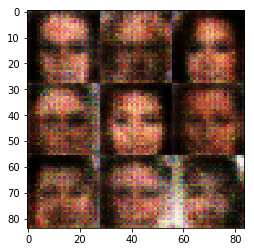

Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 2.1549
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.3219
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 3.3939
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 3.8237
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 4.6593
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 1.6188
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 4.4062
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 3.4740
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 3.6679
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 5.3618


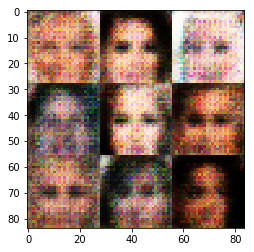

Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 3.2698
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 2.6297
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 4.3057
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 4.7691
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 3.4753
Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 3.0702
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 4.5099
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 3.9387
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 5.0555
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 5.4589


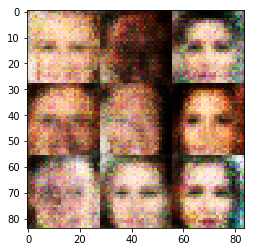

Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 3.6974
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 4.5700
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 3.8677
Epoch 1/1... Discriminator Loss: 0.4799... Generator Loss: 5.1914
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 4.4100
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 2.8185
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 4.6301
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 2.5527
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 3.1099
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 2.9406


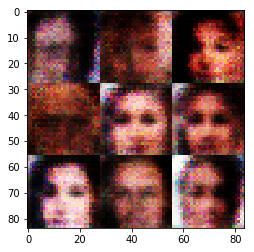

Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 2.2044
Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 3.2327
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 4.2588
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 1.6158
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 2.1688
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 3.7109
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 1.9461
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.5914
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.5604


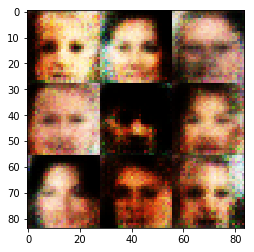

Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 7.1311
Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 3.1838
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 4.9277
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 4.2954
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.7261... Generator Loss: 0.3268
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 5.7288
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.8994


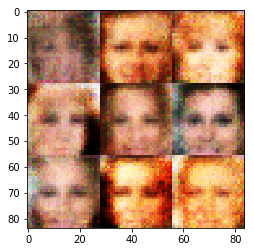

Epoch 1/1... Discriminator Loss: 1.7826... Generator Loss: 1.7833
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 5.1409
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 2.2697
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 2.0513
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.4450
Epoch 1/1... Discriminator Loss: 2.1302... Generator Loss: 0.2098
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.7603... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 3.7544
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.7285


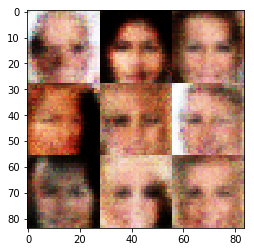

Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 2.5657
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 6.1175
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 2.5534
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 3.3222
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 4.5325
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 1.4595


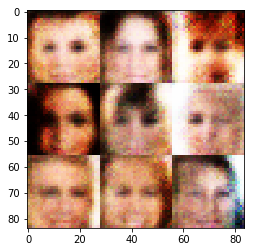

Epoch 1/1... Discriminator Loss: 2.4686... Generator Loss: 0.1434
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.3363
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 3.7452
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.4832
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 3.2942
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 1.5919
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.7821


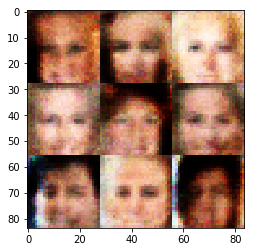

Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 4.7178
Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 3.6314
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 3.3473
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.8614
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 3.1143
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 2.9553
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 1.6370
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 5.6590
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 3.5593


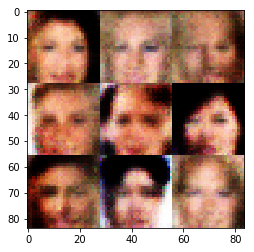

Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 2.5705
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 1.6637
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 5.4287
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.9610
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.7177


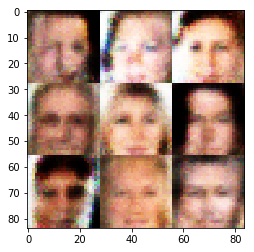

Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.6332
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 5.9856
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 2.6076
Epoch 1/1... Discriminator Loss: 3.7284... Generator Loss: 0.0503
Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 2.6211
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 3.8542
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 2.9273
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 1.8564
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 4.9489
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.8183


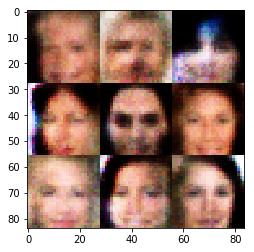

Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.9464
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 4.1013
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.2016
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 4.0342
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 3.4727
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 3.2911
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 4.6992
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.4145


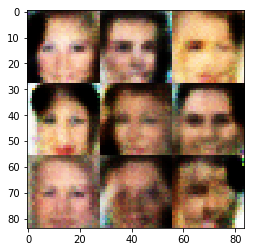

Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 4.3633
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 3.5046
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.1192
Epoch 1/1... Discriminator Loss: 2.1828... Generator Loss: 2.6594
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 4.2321
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 2.9795
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.4032
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 3.6399


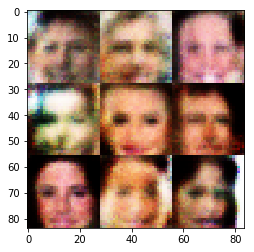

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.